In [14]:
from math import log, sqrt
import numpy as np
from numpy import exp, fft, array, pi, zeros
import matplotlib.pyplot as plt

Процедуры, которые возвращают дерево для процесса CIR

In [15]:
def compute_f(r, omega):
    return 2*sqrt(r)/omega


def compute_v(R, omega):
    if R > 0:
        return (R**2) * (omega**2)/4.0
    else:
        return 0.0


def build_volatility_tree(T, v0, kappa, theta, omega, N):
    div_by_zero_counter = 0
    f = zeros((N+1, N+1))
    f[0, 0] = compute_f(v0, omega)
    dt = float(T)/float(N)
    sqrt_dt = sqrt(dt)
    V = zeros((N+1, N+1))
    V[0, 0] = compute_v(f[0, 0], omega)
    f[1, 0] = f[0, 0]-sqrt_dt
    f[1, 1] = f[0, 0]+sqrt_dt
    V[1, 0] = compute_v(f[1, 0], omega)
    V[1, 1] = compute_v(f[1, 1], omega)

    for i in range(1, N):
        for j in range(i+1):
            f[i+1, j] = f[i, j] - sqrt_dt
            f[i+1, j+1] = f[i, j] + sqrt_dt
            V[i+1, j] = compute_v(f[i+1, j], omega)
            V[i+1, j+1] = compute_v(f[i+1, j+1], omega)

    f_down = zeros((N+1, N+1))
    f_up = zeros((N+1, N+1))
    pu_f = zeros((N+1, N+1))
    pd_f = zeros((N+1, N+1))
    for i in range(0, N):
        for j in range(i+1):
            # /*Compute mu_f*/
            v_curr = V[i][j]
            mu_r = kappa*(theta-v_curr)
            z = 0
            while V[i, j] + mu_r*dt < V[i+1, j-z] and j-z >= 0:
                z += 1
            f_down[i, j] = -z
            Rd = V[i+1, j-z]  # the next low vertice we can reach
            z = 0
            while V[i, j] + mu_r*dt > V[i+1, j+z] and j+z <= i:
                z += 1
            Ru = V[i+1, j+z]  # the next high vertice we can reach
            f_up[i, j] = z
            if Ru == Rd:
                div_by_zero_counter += 1
            pu_f[i, j] = (V[i, j]+mu_r*dt-Rd)/(Ru-Rd)

            if Ru-1.e-9 > V[i+1, i+1] or j+f_up[i][j] > i+1:
                pu_f[i][j] = 1.0
                f_up[i][j] = i+1-j
                f_down[i][j] = i-j

            if Rd+1.e-9 < V[i+1, 0] or j+f_down[i, j] < 0:
                pu_f[i, j] = 0.0
                f_up[i, j] = 1 - j
                f_down[i, j] = 0 - j
            pd_f[i, j] = 1.0 - pu_f[i][j]
    return [V, pu_f, pd_f, f_up, f_down]

Процедуры для fft в радианах

In [16]:
def make_rad_fft(f_x, d):
    '''
    Вычисляет преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_x - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-M*dx/2, M*dx/2] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
    '''
    dx = d
    M = len(f_x)
    
    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])
    #учитываем порядок хранения
    sign_change_l = fft.fftshift(sign_change_l)

    f = sign_change_k * f_x
    f_hat = dx * sign_change_l * fft.fft(f)
    
    # избегаем особенностей хранения результатов fft, нам они не нужны.
    return f_hat

def make_rad_ifft(f_hat_xi, d):
    '''
    Вычисляет обратное преобразование Фурье без двух "пи" в показателе экспоненты
    
    Параметры:
    
    f_xi - массив значений функции, задаваемый "как есть", без особенностей хранения
    и определённый на диапазоне [-pi/d, pi/d] в M = 2**N равноудалённых точках, без последней.
    
    d = dx - желаемый шаг по переменной x, после того, как ifft отработает
    
    Области определения:
    
    xi_space = np.linspace( -pi/dx, pi/dx, num = M, endpoint = False)
    x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)

    '''
    dx = d
    M = len(f_hat_xi)

    sign_change_k = np.array([(-1)**k for k in range(0, M)])
    sign_change_l = np.array([(-1)**l for l in range(0, M)])

    f =  (1/(dx)) * sign_change_k * fft.ifft(sign_change_l * f_hat_xi)
    return f

Код для вычисления цены

In [18]:
# option parameters
T = 1
H_original = 90  # limit
K_original = 100.0  # strike
r_premia = 10  # annual interest rate
r = log(r_premia/100 + 1)

# Heston model parameters
V0 = 0.1  # initial volatility
kappa = 2.0  # heston parameter, mean reversion
theta = 0.1  # heston parameter, long-run variance
sigma = omega = 0.2  # heston parameter, volatility of variance.
# Omega is used in variance tree, sigma - everywhere else
rho = 0.5  # heston parameter #correlation

# method parameters
N = 5  # number_of_time_steps
delta_t = T/N

rho_hat = sqrt(1 - rho**2)
print('rho_hat =' , rho_hat)

q = 1.0/delta_t + r
print('q = ', q)
factor = (q*delta_t)**(-1)
print('Множитель каждого шага =', factor)

rho_hat = 0.8660254037844386
q =  5.095310179804325
Множитель каждого шага = 0.9812945284112251


In [19]:
def G(S, K):
    """the payoff function of a put option. Nothing to do with barrier"""
    return max(K-S, 0)
M = 2**16

# потому что dy нужно править много где, пока запомним, что dy = dx
dx = 0.001

x_space = np.linspace( -M*dx/2, M*dx/2, num = M, endpoint = False)
u_space = np.linspace(-pi/dx, pi/dx, num = M, endpoint = False)
du = u_space[1] - u_space[0]

print("В вычислениях будет использовано всего", M, "точек")
print("du = ", du)
print("Частота меняется от ", -pi/dx, "до", pi/dx)

print("dx = ", dx)
print("Пространственная переменная меняется от ", x_space[0], "до", x_space[M-1])

print("Отношение длин диапазонов пространство/частота:", (x_space[M-1] -  x_space[0])/(2*pi/dx))
print("Отношение длин диапазонов частота/пространство:", (2*pi/dx)/(x_space[M-1] -  x_space[0]))

L = 1  # scaling coefficient
y_min = L * log(0.5)
y_max = L * log(2.0)

K = log(K_original/H_original)
H = log(H_original/H_original)
y_space = x_space # prices array

print('L =', L)
print("Диапазон пространства в лог. шкале в терминах L был бы от ", y_min, 'до', y_max)

В вычислениях будет использовано всего 65536 точек
du =  0.0958737992428
Частота меняется от  -3141.592653589793 до 3141.592653589793
dx =  0.001
Пространственная переменная меняется от  -32.768 до 32.767
Отношение длин диапазонов пространство/частота: 0.0104302191955
Отношение длин диапазонов частота/пространство: 95.8752621833
L = 1
Диапазон пространства в лог. шкале в терминах L был бы от  -0.6931471805599453 до 0.6931471805599453


### Замечание о естественных ценах

Мы подбираем равномерную сетку в логарифмической шкале, но она не будет таковой в линейной.

Существует грубая оценка на корректность работы алгоритма при различных параметрах, которую я принёс на бумаге. Её нужно либо перенести сюда, либо отвергнуть.


Строим дерево с параметрами. Отметим, что при малых N = (1,2) процедура не работает из-за делений на ноль

In [20]:
if 2 * kappa * theta < sigma**2:
    print("Warning, Novikov condition is not satisfied, the volatility values could be negative")
r = log(r_premia/100 + 1)
omega = sigma

first_step_of_return = [elem + V0*rho/sigma for elem in x_space]
original_prices_array = H_original * exp(first_step_of_return)
# making volatilily tree
markov_chain = build_volatility_tree(T, V0, kappa, theta, omega, N)
V = markov_chain[0]
pu_f = markov_chain[1]
pd_f = markov_chain[2]
f_up = markov_chain[3]
f_down = markov_chain[4]

Теперь, когда дерево у нас есть, можно создавать пространственную переменную.
Проблема состоит в том, что пространство меняется в каждой вершине цепи так, чтобы барьер оказывался в центре.
Поэтому нужно хранить много пространств, что не щадит память совершенно.

$ y_j (n,k) = x_j - {\rho \over \sigma} V (n,k) $

$y = \ln(S/H) - {\rho \over \sigma} V$

$y[j][n][k]$ начальное сосотяние процессов цены после замены


In [24]:
y = zeros((len(x_space), len(V), len(V[N])))
for j in range(len(x_space)):
    for n in range(len(V)):
        for k in range(len(V[N])):
            y[j][n][k] = x_space[j] - rho/sigma * V[n, k]

print("y_j_n_k consctuction completed")

xi_space = u_space

F = zeros((len(y), len(V), len(V[N])), dtype=complex)
for j in range(len(y)):
    for k in range(len(V[N])):
        F[j, N, k] = G(H_original * exp(y[j][N][k] + rho / sigma * V[N, k]), K_original)

# when the variance is less than that, is is reasonable to assume it to be zero, which leads to simpler calculations
treshold = 1e-6
discount_factor = exp(r*delta_t)

y_j_n_k consctuction completed


In [ ]:
# Можно попробовать визуализировать начальные условия:
# for k in range(len(V[N])):
#     answers_local = array([F[j][N][k] for j in range(len(F))])
#     original_prices_space_local = array([H_original * exp(y[j][N][k] + rho / sigma * V[N, k]) for j in range(len(F))])
#     plt.plot(original_prices_space_local[(original_prices_space_local > 0) & (original_prices_space_local<200)], 
#              answers_local[(original_prices_space_local > 0) & (original_prices_space_local<200)].real)
#     plt.show()

4of4


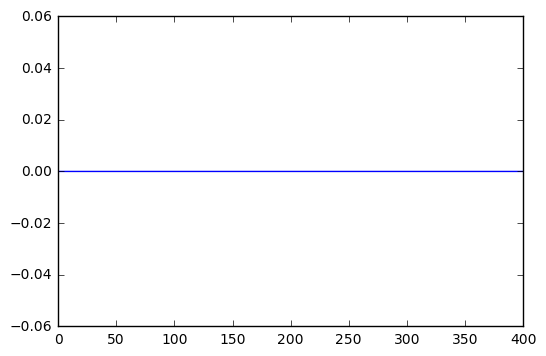

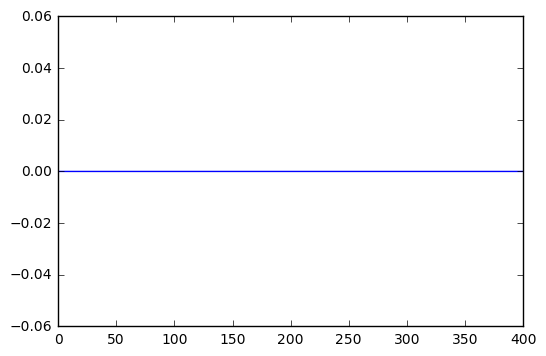

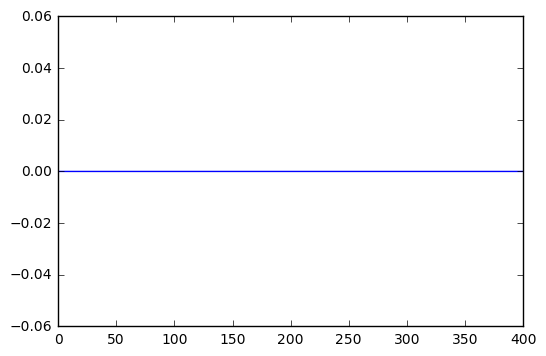

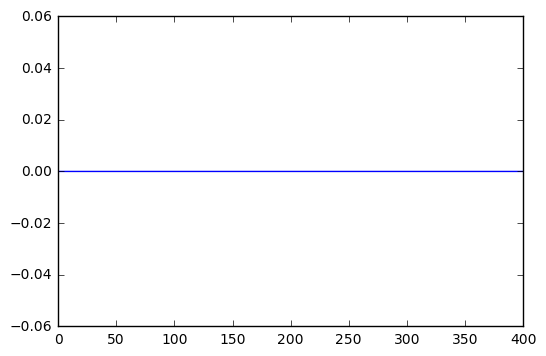

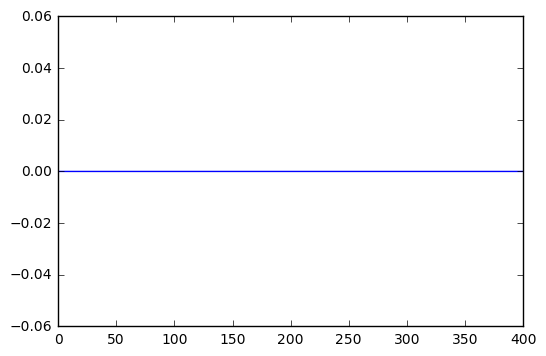

3of4


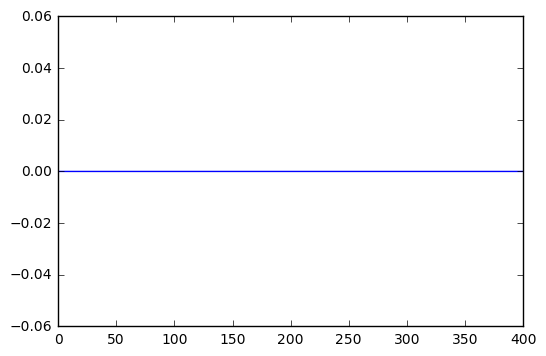

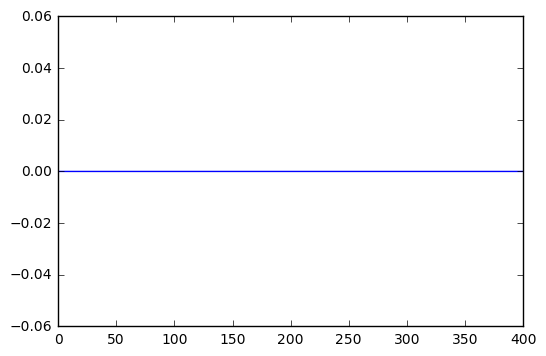

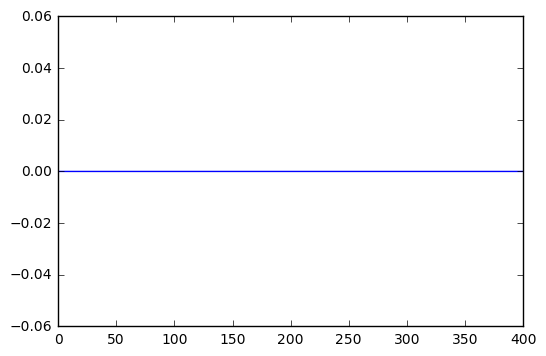

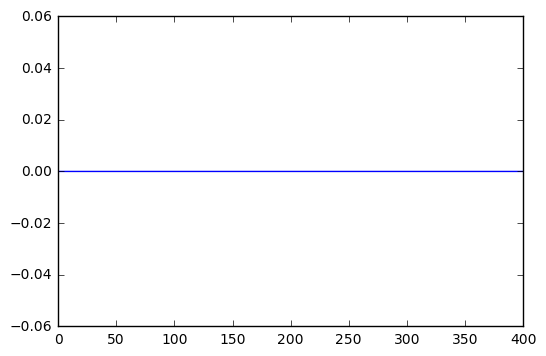

2of4


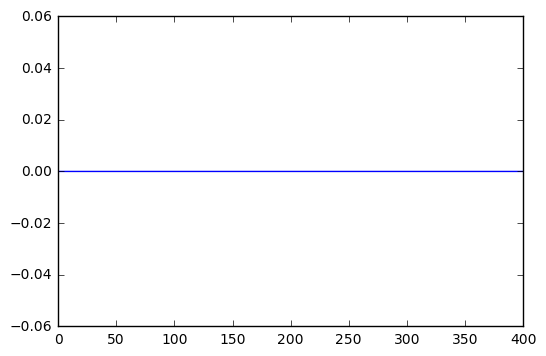

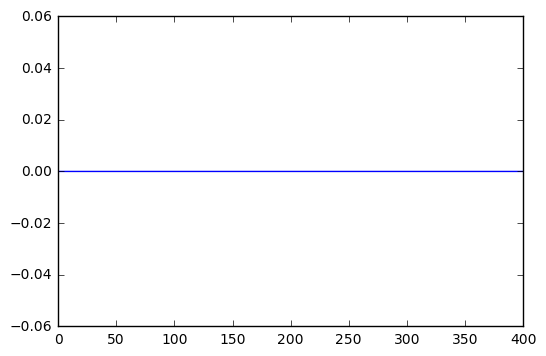

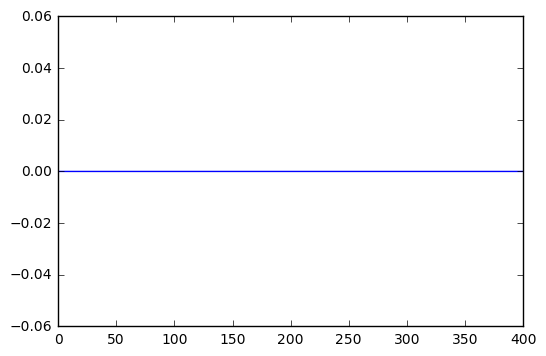

1of4


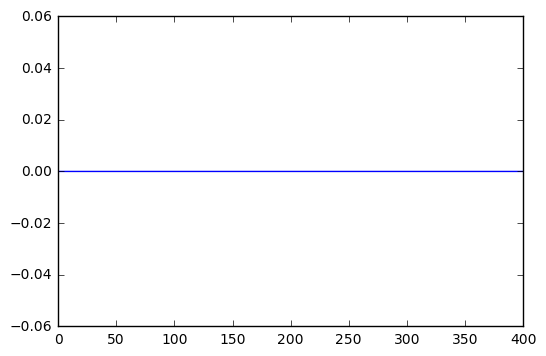

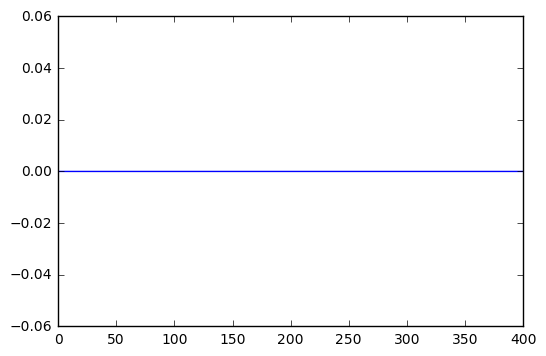

0of4


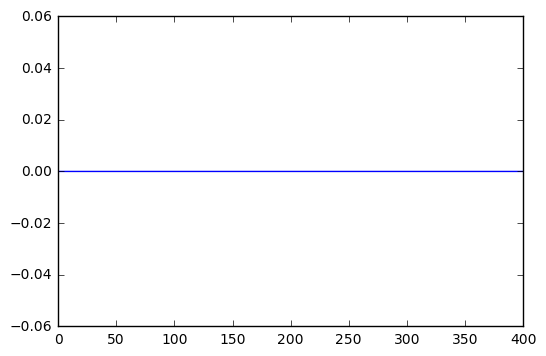

In [10]:
for n in range(len(V[N]) - 2, -1, -1):
    print(str(n) + "of" + str(len(V[N]) - 2))
    for k in range(n+1):
        answers_local = array([F[j][n][k] for j in range(len(F))])
        original_prices_space = array([H_original * exp(y[j][N][k] + rho / sigma * V[N, k]) for j in range(len(F))])
        plt.plot(original_prices_space[(original_prices_space > 0) & (original_prices_space < 400)], 
             answers_local[(original_prices_space > 0) & (original_prices_space < 400)].real)
        plt.show()
        # to calculate the binomial expectation one should use Antonino's matrices f_up and f_down
        # the meaning of the containing integers are as follows - after (n,k) you will be in
        # either (n+1, k + f_up) or (n+1, k - f_down). We use k_u and k_d shorthands, respectively
        k_u = k + int(f_up[n][k])
        k_d = k + int(f_down[n][k])

        # initial condition of a step
        f_n_plus_1_k_u = array([F[j][n + 1][k_u] for j in range(len(F))])
        f_n_plus_1_k_d = array([F[j][n + 1][k_d] for j in range(len(F))])

        H_N_k = - (rho / sigma) * V[n, k]  # modified barrier
        local_domain = array([y[j][n][k] for j in range(len(y))])
        indicator = np.where((local_domain>=0), 1, 0)

        if V[n, k] >= treshold:
            # set up variance-dependent parameters for a given step
            sigma_local = rho_hat * sqrt(V[n, k])
            gamma = r - 0.5 * V[n, k] - rho/sigma * kappa * (theta - V[n, k]) # also local

            # beta_plus and beta_minus
            beta_minus = - (gamma + sqrt(gamma**2 + 2*sigma_local**2 * q))/sigma_local**2
            beta_plus = - (gamma - sqrt(gamma**2 + 2*sigma_local**2 * q))/sigma_local**2

            # factor functions
            phi_plus_array = array([beta_plus/(beta_plus - 1j*2*pi*xi) for xi in xi_space])
            phi_minus_array = array([-beta_minus/(-beta_minus + 1j*2*pi*xi) for xi in xi_space])

            # factorization calculation
            f_n_k_u = factor * \
                      fft.ifft(phi_minus_array *
                               fft.fft(indicator * 
                                       fft.ifft(phi_plus_array * 
                                                fft.fft(f_n_plus_1_k_u))))

            f_n_k_d = factor * \
                      fft.ifft(phi_minus_array *
                               fft.fft(indicator * 
                                       fft.ifft(phi_plus_array * 
                                                fft.fft(f_n_plus_1_k_d))))

        elif V[n, k] < treshold:
            f_n_plus_1_k_u = [F[j][n+1][k_u] for j in range(len(F))]
            f_n_k_u = discount_factor * f_n_plus_1_k_u

            f_n_plus_1_k_d = [F[j][n + 1][k_d] for j in range(len(F))]
            f_n_k_d = discount_factor * f_n_plus_1_k_d

        f_n_k = f_n_k_u * pu_f[n, k] + f_n_k_d * pd_f[n, k]

#         for j in range(len(f_n_k)):
#             # here we try some cutdown magic. The procedure without it returns great bubbles to the right
#             # from the strike. And the more L the greater this bubble grows.
#             # what we are going to do there is to try to cut off all the values on prices greater than, say,
#             # 4 times bigger then the strike
#             # we use S>4K and, therefore, y > ln(4K/H) + (pho/sigma)*V inequality to do this
#             if y[j][n][k] < log(3.5*K_original/H_original + (rho/sigma) * V[n][k]):
#                 F[j][n][k] = f_n_k[j]
#             else:
#                 F[j][n][k] = complex(0)


<class 'numpy.ndarray'>


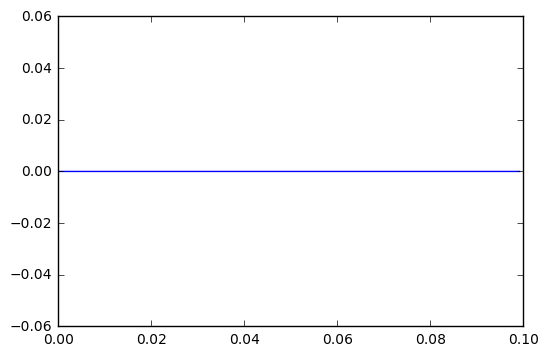

[  8.09111204e-70   8.17242907e-70   8.25456334e-70 ...,   9.72772306e-02
   9.82548830e-02   9.92423610e-02]


In [74]:
answers_list = array([F[j][0][0] for j in range(len(F))])
print(type(original_prices_array))
# for j in range(len(F)):
#    tree_to_csv_file(F[j], "../output/routine/answers/F" + str(original_prices_array[j]) + ".csv")
plt.plot(original_prices_array[(original_prices_array > 0) & (original_prices_array < 0.1)], 
         answers_list[(original_prices_array > 0) & (original_prices_array < 0.1)].real)
plt.show()

print(original_prices_array[(original_prices_array > 0) & (original_prices_array < 0.1)])

/home/basil/anaconda3/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


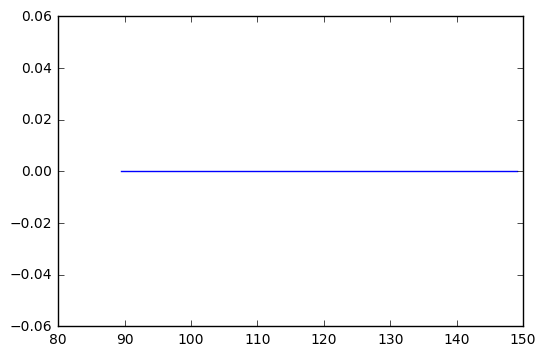

[ 0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0

In [26]:
plt.plot(original_prices_array, answers_list)
plt.show()
print(answers_list * np.where(answers_list!=complex(0,0), 1, np.nan))